In [35]:
import pandas as pd
import numpy as np

df = pd.read_excel("Telco_customer_churn.xlsx")
df.head()

df.shape


(7043, 33)

In [36]:
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [37]:
#This sets empty values from "Total Charges" column to NaN and sets the type as float. 
df["Total Charges"] = df["Total Charges"].replace(" ", np.nan).astype(float)


/var/folders/q_/q_8374nd2lz33xgn_4vmrscc0000gn/T/ipykernel_47033/2058711184.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Total Charges"] = df["Total Charges"].replace(" ", np.nan).astype(float)


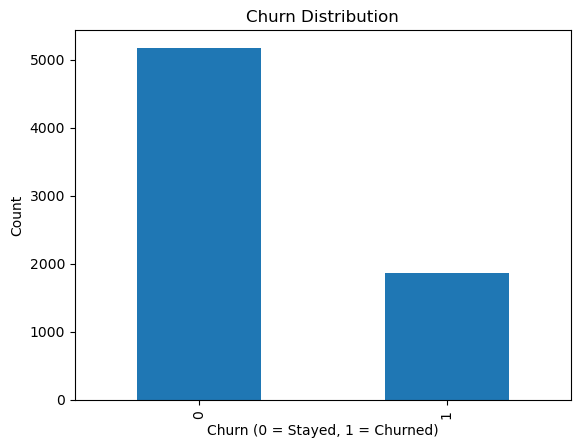

In [38]:
import matplotlib.pyplot as plt

y.value_counts().plot(kind="bar")
plt.title("Churn Distribution")
plt.xlabel("Churn (0 = Stayed, 1 = Churned)")
plt.ylabel("Count")
plt.show()


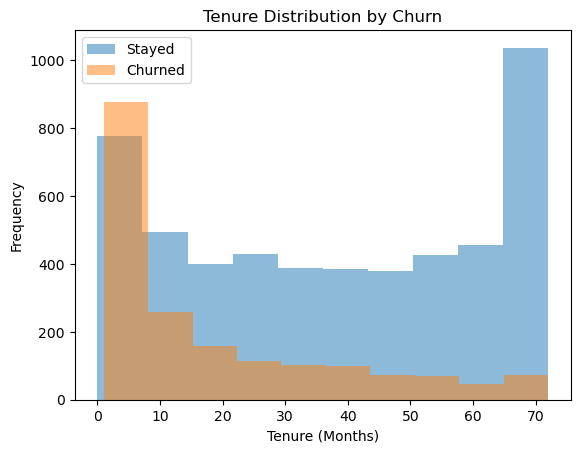

In [39]:
plt.figure()
df[df["Churn Value"] == 0]["Tenure Months"].plot(kind="hist", alpha=0.5, label="Stayed")
df[df["Churn Value"] == 1]["Tenure Months"].plot(kind="hist", alpha=0.5, label="Churned")
plt.legend()
plt.title("Tenure Distribution by Churn")
plt.xlabel("Tenure (Months)")
plt.show()


In [40]:
# Target
y = df["Churn Value"]

# Drop target, leakage, and non-useful columns
X = df.drop(
    columns=[
        "Churn Value",   
        "Churn Label",   
        "Churn Score",   
        "CLTV",          # post-churn / future info
        "Count",         
        "Churn Reason",  # only known after churn
        "Customer ID",
        "Zip Code",
        "Lat Long",
        "Country",
        "State",
        "City",
    ],
    errors="ignore"      
)


In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [42]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression


In [43]:
# Separate feature types
# The below code seperates the features to numbers and cetegories
num_features = X_train.select_dtypes(include=["int64", "float64"]).columns
cat_features = X_train.select_dtypes(include=["object"]).columns

# Force categorical columns to be strings (fixes mixed-type error)
for col in cat_features:
    X_train[col] = X_train[col].astype(str)
    X_test[col]  = X_test[col].astype(str)
    
# Pipelines
# Here, all missing values or NaN are replaced by the column median and numeric features are standardized
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

#Missing categorical values are filled with most common category on the feature and one-hot encode all the categorical features
categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

#Applying pipelines to numeric and categorical features, combining them to a resulting clean dataset
preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, num_features),
    ("cat", categorical_pipeline, cat_features)
])

# Full model pipeline
model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])


In [44]:
X.columns


Index(['CustomerID', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges'],
      dtype='object')

In [45]:
model.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [46]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8034066713981547
ROC AUC: 0.8479681727763569
Confusion Matrix:
 [[917 118]
 [159 215]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.65      0.57      0.61       374

    accuracy                           0.80      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.80      0.80      1409



/opt/miniconda3/envs/cs171/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/miniconda3/envs/cs171/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


The above result shows us that the model has an accuracy of 0.8.
This indicates that out of every 100 customers, the model was able to accurately predict 80 customers. 
The ROC AUC value of 0.847 tells us that about 84% of the time, the model will correctly label the customers who are likely to churn vs those who will stay. 
The confusion matrix tells us that for the test data set, the model has successfully predicted 912 customers who stayed and wrongly classifed 160 customers who churned as stayed. 
Likewise, the model mistakenly labeled 123 customers as stayed while they actually churned. The model also accurately deteced 214 clients as stay when they indeed stay. 